## Home Credit Default Risk

## PART 5: Подбор гиперпараметров

В этом ноутбуке будет подбор гиперпараметров модели бустинга lightgbm. Я попробую воспользоваться библиотекой hyperopt и алгоритмом оптимизации Tree-Structured Parzen Estimators (TPE). Признаки возьму те, которые были подобраны в прошлом ноутбуке с Boruta. 

In [147]:
import numpy as np
import pandas as pd
import csv

from cross_validation_module import *
from submission_module import *

import pickle
from tqdm import tqdm_notebook
import colorama 
from time import time
import lightgbm as lgb
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set_style('whitegrid')
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_info_columns', 250)

In [148]:
with open('columns_vocab.pkl', 'rb') as f: 
    columns_vocab = pickle.load(f)
    
APPL_ID = 0
columns_vocab[APPL_ID].keys()

dict_keys(['column_id', 'column_target', 'columns_binary', 'columns_category', 'columns_float', 'columns_float_avg', 'columns_float_mode', 'columns_float_medi', 'columns_float_social_circle', 'new_features', 'columns_category_ohe', 'columns_float_log', 'columns_social_circle_log', 'boruta_110'])

In [149]:
with open('df_application_train_upd.pkl', 'rb') as f: 
    df_application_train = pickle.load(f)
    
with open('df_application_test_upd.pkl', 'rb') as f: 
    df_application_test = pickle.load(f)
#----------------------------------------------------#
with open('df_train_log_features.pkl', 'rb') as f: 
    df_train_log_features = pickle.load(f)
    
with open('df_test_log_features.pkl', 'rb') as f: 
    df_test_log_features = pickle.load(f)
#----------------------------------------------------#
with open('df_train_new_features.pkl', 'rb') as f: 
    df_train_new_features = pickle.load(f)
    
with open('df_test_new_features.pkl', 'rb') as f: 
    df_test_new_features = pickle.load(f)

In [150]:
df_application_train = pd.concat([df_application_train, df_train_log_features, df_train_new_features], axis=1)
df_application_test = pd.concat([df_application_test, df_test_log_features, df_test_new_features], axis=1)

print('application train:', df_application_train.shape)
print('application test:', df_application_test.shape)

application train: (307511, 374)
application test: (48744, 373)


In [151]:
column_id = columns_vocab[APPL_ID]['column_id']
column_target = columns_vocab[APPL_ID]['column_target']
columns = columns_vocab[APPL_ID]['boruta_110']

In [152]:
X_train, X_holdout, y_train, y_holdout = train_test_split(df_application_train[columns], 
                                                          df_application_train[column_target].values, 
                                                          shuffle=True, 
                                                          stratify=df_application_train[column_target].values, 
                                                          test_size=0.2, 
                                                          random_state=42)

dtrain = lgb.Dataset(X_train, label=y_train)

In [153]:
ITERATION = 0
current_best_score = 0.0

N_FOLDS = 5
NUM_ROUNDS = 200
EARLY_STOPPING_ROUNDS = 10

N_HYPEROPT_PROBES = 400
HYPEROPT_ALGO = tpe.suggest  

out_file = 'lgbm_trials.csv'

def get_params(space):
    px = dict()

    # Core parameters
    #px['boosting_type']='gbdt'
    px['objective'] ='binary'
    px['learning_rate'] = space['learning_rate']
    px['num_leaves'] = int(space['num_leaves'])
    px['num_threads'] = 4
    px['seed'] = 0
    
    # Learning Control Parameters
    px['max_depth'] = int(space['max_depth'])
    px['min_data_in_leaf'] = int(space['min_data_in_leaf'])
    px['bagging_fraction'] = space['bagging_fraction']
    px['bagging_freq'] = 5
    px['feature_fraction'] = space['feature_fraction']
    px['lambda_l1'] = space['lambda_l1'],
    px['lambda_l2'] = space['lambda_l2'],
        
    # Objective Parameters
    px['scale_pos_weight'] = 11
    
    # Metric Parameters
    px['metric'] = 'auc'

    return px

In [154]:
def objective(space):
    global ITERATION, current_best_score, dtrain, X_train, y_train, X_holdout, y_holdout

    ITERATION += 1
    print('\nLightGBM ITERATION #{} current_best_score={:7.5f}'.format(ITERATION, current_best_score) )

    lgb_params = get_params(space)
    print('Params: ', lgb_params)
    
    start_time = time()
    cv_results = lgb.cv(params = lgb_params, 
                       train_set = dtrain, 
                       num_boost_round = NUM_ROUNDS, 
                       nfold = N_FOLDS, 
                       stratified=True, 
                       shuffle=True, 
                       early_stopping_rounds = EARLY_STOPPING_ROUNDS, 
                       verbose_eval = False, 
                       show_stdv = False, 
                       seed = 0, 
                       )
    
    cv_score = np.max(cv_results['auc-mean'])
    n_estimators = int(np.argmax(cv_results['auc-mean']) + 1)
    
    print('CV finished: n_estimators={}, cv_score={:7.6f}'.format(n_estimators, cv_score))
    
    model = lgb.train(lgb_params,
                      dtrain,
                      num_boost_round=n_estimators,
                      verbose_eval=False)
    
    preds = model.predict(X_holdout, num_iteration=n_estimators)
    holdout_score = roc_auc_score(y_holdout, preds)
    print('holdout_score={}'.format(holdout_score))
    
    run_rime = (time() - start_time)/60
    
    if holdout_score > current_best_score:
        current_best_score = holdout_score
        print(colorama.Fore.GREEN + 'NEW BEST SCORE={}'.format(current_best_score) + colorama.Fore.RESET)
    
    # Loss must be minimized
    loss = 1 - holdout_score
    
    with open(out_file, 'a') as f: 
        writer = csv.writer(f)
        writer.writerow([cv_score, holdout_score, lgb_params, ITERATION, n_estimators, run_rime])
    
    return {'loss': loss, 'params': lgb_params, 'status': STATUS_OK}

In [155]:
space ={
        'max_depth': hp.quniform("max_depth", 3, 10, 1),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.005), np.log(0.2)),
        'num_leaves': hp.quniform('num_leaves', 20, 128, 1),
        'min_data_in_leaf':  hp.quniform ('min_data_in_leaf', 20, 100, 1),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.7, 1.0),
        'feature_fraction': hp.uniform('feature_fraction', 0.75, 1.0),
        'lambda_l1': hp.uniform('lambda_l1', 0.0, 1.0),
        'lambda_l2': hp.uniform('lambda_l2', 0.0, 1.0),
        'min_split_gain': hp.uniform('min_split_gain', 0, 0.03)
       }

В этот файл будут записываться результаты подбора параметров по мере окончания итераций, чтобы можно было посмотреть хоть какие-нибудь результаты, если что-то пойдет не так. 

In [ ]:
# with open(out_file, 'w') as f:
#     writer = csv.writer(f))
#     writer.writerow(['cv_score', 'holdout_score', 'params', 'iteration', 'estimators', 'time']

Здесь были долгие вычисления (ячейку очистила):

In [ ]:
%%time
trials = Trials()
best = hyperopt.fmin(fn=objective,
                     space=space,
                     algo = HYPEROPT_ALGO,
                     max_evals=N_HYPEROPT_PROBES,
                     trials=trials,
                     verbose=1)

In [156]:
results = pd.read_csv(out_file)

results.sort_values('holdout_score', ascending = False, inplace = True)
results.reset_index(inplace=True, drop=True)
results.head()

,cv_score,holdout_score,params,iteration,estimators,time
0,0.755218,0.760220,"{'objective': 'binary', 'learning_rate': 0.037...",363,200,2.413047
1,0.754230,0.760124,"{'objective': 'binary', 'learning_rate': 0.040...",374,178,2.358654
2,0.754921,0.759999,"{'objective': 'binary', 'learning_rate': 0.034...",388,200,2.427199
3,0.755111,0.759925,"{'objective': 'binary', 'learning_rate': 0.033...",390,200,2.461243
4,0.754766,0.759914,"{'objective': 'binary', 'learning_rate': 0.038...",400,198,2.191405


Посмотрим, как менялся ROC-AUC на каждой итерации. Он должен расти, поскольку алгоритм подбора параметров адаптивный и использует информацию с предыдущих итераций.

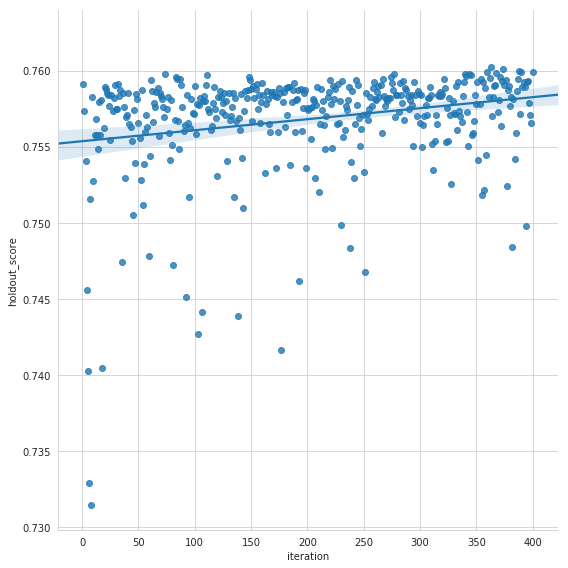

In [157]:
sns.lmplot('iteration', 'holdout_score', data = results, size = 8);

Лучшие параметры: 

In [158]:
import ast

# Convert from a string to a dictionary
best_params = ast.literal_eval(results.loc[0, 'params'])
# fix little error
best_params['lambda_l1'] = best_params['lambda_l1'][0]
best_params['lambda_l2'] = best_params['lambda_l2'][0]
best_params

{'objective': 'binary',
 'learning_rate': 0.037760618278259224,
 'num_leaves': 52,
 'num_threads': 4,
 'seed': 0,
 'max_depth': 9,
 'min_data_in_leaf': 89,
 'bagging_fraction': 0.8057957690608358,
 'bagging_freq': 5,
 'feature_fraction': 0.9661173606302474,
 'lambda_l1': 0.9390325824715245,
 'lambda_l2': 0.026451288409226184,
 'scale_pos_weight': 11,
 'metric': 'auc'}

Проверим результат подбора на той кросс-валидации, которую использовали в предыдущих ноутбуках:

In [159]:
folds = get_cv_folds(df_application_train, column_target, n_splits=5)

In [162]:
%%time
train_roc_auc, valid_roc_auc = cross_validation_lightgbm(df_application_train, columns, column_target, folds, \
                                    params=best_params, num_rounds=200, metric=roc_auc_score, 
                                    early_stopping_rounds=None, verbose_eval=False)

print('mean train score:', np.mean(train_roc_auc))
print('mean valid score:', np.mean(valid_roc_auc))

mean train score: 0.8210276651909446
mean valid score: 0.7555668743975794
CPU times: user 10min 38s, sys: 7.9 s, total: 10min 45s
Wall time: 3min 33s


С параметрами по умолчанию результаты были следующие: train score = 0.80687, test score = 0.75390. Таким образом, получилось улучшить модель. Кроме того, я проверила, что после примерно 400 итераций бустинга (параметр num_rounds) модель начинает переобучаться. Подберем количество деревьем в узком диапазоне от 200 до 400 деревьев. 

In [ ]:
train_scores = []
valid_scores = []
n_estimators = np.arange(200, 440, step=20)

for num_rounds in tqdm_notebook(n_estimators):
    train_roc_auc, valid_roc_auc = cross_validation_lightgbm(df_application_train, columns, column_target, folds, \
                                    params=best_params, num_rounds=num_rounds, metric=roc_auc_score, 
                                    early_stopping_rounds=None, verbose_eval=False)
    
    mean_train_score = np.mean(train_roc_auc)
    mean_valid_score = np.mean(valid_roc_auc)
    
    train_scores.append(mean_train_score)
    valid_scores.append(mean_valid_score)
    
    print('n_estimators:', num_rounds)
    print('train score:', mean_train_score)
    print('valid score:', mean_valid_score)
    print('-----------------------------------------------------------')

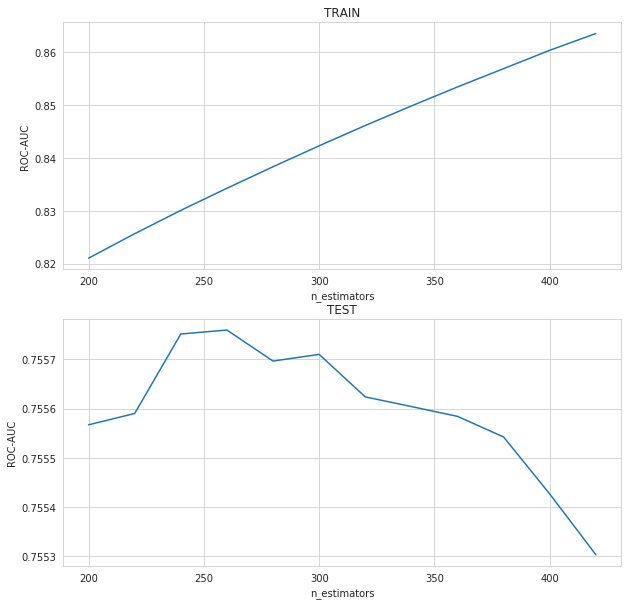

In [163]:
fig, axes = plt.subplots(nrows=2, figsize=(10, 10))
axes[0].plot(n_estimators, train_scores)
axes[1].plot(n_estimators, valid_scores)

axes[0].set_title('TRAIN')
axes[1].set_title('TEST')
axes[0].set_xlabel('n_estimators')
axes[1].set_xlabel('n_estimators')
axes[0].set_ylabel('ROC-AUC')
axes[1].set_ylabel('ROC-AUC')
plt.show()

In [ ]:
# boruta, rank <= 110
# local train score = 0.8342454641982247
# local test score = 0.7557594422303531

# private score = 0.74480
# public score = 0.74397
predict_submission_lightgbm(df_application_train, df_application_test, 
                            columns, column_target, best_params, 260, 
                            'boruta110_tuned_lgbm', '260est')

Итоговый результат на kaggle: public **0.74397**, private **0.74480**. Это лучший из всех моих сабмитов и на публичной таблице, и на приватной. Таким образом это пока все, что я смогла выжать из данных **application_{train|test}.csv**. Если бы я участвовала в этом соревновании, то я бы остановилась на этом наборе признаков и продолжила бы смотреть другие файлы с данными. 

<img src='kaggle.png' />